In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np
from datetime import datetime
from collections import defaultdict, OrderedDict

import term_hiearchy
import re
import tqdm.notebook

sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Descriptive Statistics


Describe the terms-used (grouped into categories) in incels.is inceldom threads in the 2021-04-15 scrape:  

## Parse Data

Parse dataframes generated by `generate_datasets_hierarchy.py -i 2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/complete_submissions_index.txt`

- `2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_query_data.tsv`: contains all hits to search terms in the glossary from Jaymes/Mike and encoded in `generate_datasets.py`

- `2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_user_data.tsv`: contains a database of all the users

- `2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_users_per_thread.tsv`: count of number of unique users in each thread

- `term_hiearchy.hierarchy` contains the regular expressions used by `generate_datasets_hiearchy.py` in a series of OrderedDictionaries to retain priorities


In [2]:
query_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hiearchy_query_data.tsv', sep='\t', lineterminator='\n')

# userdata will include more users than post data usernames as it includes users with deleted posts
user_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_user_data.tsv', sep='\t', lineterminator='\n')
user_data = user_data.sort_values(['username', 'number_of_posts'], ascending=False).drop_duplicates(subset=["username"], keep="first")
post_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_post_data.tsv', sep='\t', lineterminator='\n')

term_hiearchy_dict = term_hiearchy.hierarchy

# build a dictionary of term priorities
term_priorities = []
ix = 0
for term_category, terms in term_hiearchy_dict.items():
    for term in term_hiearchy_dict[term_category]:
        term_priorities.append((term, ix))
        ix+=1

term_priorities = OrderedDict(term_priorities)

query_data['term_priority'] = query_data['query_term'].apply(lambda x: term_priorities[x])
# filter out 

Now we need to clean-up some false positive hits to "JAP" as part of the words "japan" and "japanese"


In [3]:
jap_fp = query_data[(query_data['query_term'] == 'JAP') & (query_data['query_word_after_match'].str.lower().isin(['an', 'anese', 'cel']))].index
query_data = query_data.drop(jap_fp)

jb_fp = query_data[(query_data['query_term'] == 'JB') & ((query_data['query_word_after_match'].str.len() == 1) | query_data['query_word_after_match'].str.lower().str.contains('wmax'))].index
query_data = query_data.drop(jb_fp)

co_fp = query_data[query_data['query_term'] == 'CO'].index
query_data = query_data.drop(co_fp)

trans_fp = query_data[(query_data['query_term'] == 'trans') & \
    (~query_data['query_word_after_match'].str.lower().isin(['sexuals', 'exual', 'sexual', 'phobia', 'men', 'man', 'rights', 'sexualism', 'exualism', 'vestites', 'sexuality', 'exuality', 'cels']))].index
query_data = query_data.drop(trans_fp)

hole_fp = query_data[(query_data['query_term'] == 'hole') & (~query_data['query_sentence'].str.contains(' hole '))].index
query_data = query_data.drop(hole_fp)

puta_fp = query_data[(query_data['query_term'] == 'puta') & (~query_data['query_sentence'].str.contains(' puta'))].index
query_data = query_data.drop(puta_fp)

bim_fp = query_data[(query_data['query_term'] == 'bim') & (~query_data['query_word_after_match'].str.lower().str.startswith('b', na=False))].index
query_data = query_data.drop(bim_fp)

gash_fp = query_data[(query_data['query_term'] == 'gash') & (query_data['query_word_after_match'].str.lower() == 'i')].index
query_data = query_data.drop(gash_fp)

skirt_fp = query_data[(query_data['query_term'] == 'skirt')].index
query_data = query_data.drop(skirt_fp)

scag_fp = query_data[(query_data['query_term'] == 'scag') & (~query_data['query_tidied_match'].str.contains('skag'))].index
query_data = query_data.drop(scag_fp)

pj_fp = query_data[(query_data['query_term'] == 'PJ')].index
query_data = query_data.drop(pj_fp)

lez_fp = query_data[(query_data['query_term'] == 'lez') & (~query_data['query_sentence'].str.lower().str.contains(' lez'))].index
query_data = query_data.drop(lez_fp)

gasher_fp = query_data[(query_data['query_term'] == 'gasher')].index
query_data = query_data.drop(gasher_fp)

hog_fp = query_data[(query_data['query_term'] == 'hog') & (~query_data['query_sentence'].str.lower().str.contains(' hog'))].index
query_data = query_data.drop(hog_fp)

hogwash_fp = query_data[(query_data['query_term'] == 'hog') & (query_data['query_word_after_match'] == 'wash')].index
query_data = query_data.drop(hogwash_fp)


Then we need to tidy up the terms defined as "Racist Misogyny" if followed by another term lower in the term hierarchy. We will do this by evaluating the neighbouring words using the regular expressions and if they hit then renaming the category to "Racist Misogyny" otherwise we leave it as is 'Racist Misogyny (if followed by other term)'.  After this runs we can drop all the remaining "'Racist Misogyny (if followed by other term)'" as this indicates they didn't have a neighbouring word that hit one of the regular expressions. 

In [4]:
# tidy up racist misogyny terms that aren't definitely racist misogyny (i.e., not follow by another term)
def check_neighbouring_words(row):
    if row['query_category'] != 'Racist Misogyny (if followed by other term)':
        return row
    
    neighour = True
    for term_category, terms in term_hiearchy_dict.items():
        for term, term_regex in term_hiearchy_dict[term_category].items():
            if not pd.isna(row['query_word_before_match']):
                if re.match(term_regex, row['query_word_before_match']):
                    row['query_category'] = 'Racist Misogyny'
                    return row

            if not pd.isna(row['query_word_after_match']):
                if re.match(term_regex, row['query_word_after_match']):
                    row['query_category'] = 'Racist Misogyny'
                    return row  
    return row

query_data = query_data.apply(check_neighbouring_words, axis=1)
# drop any remaining "Racist Misogyny (if followed by other term)" because if its still there after
# checking for neighbouring words then it isn't valid
query_data = query_data[query_data['query_category'] != 'Racist Misogyny (if followed by other term)']

Then we need to look at hits neighbouring each other and keep the term with the highest priority (from the term hierachy dictionaries)

In [5]:
# apply hierarchy
indices_to_remove = set()

# for each thread get all the hits from that thread
for group, hits_in_same_sentence in query_data.groupby(['thread_url', 'post_position', 'sentence_position']):  
    if hits_in_same_sentence.shape[0] > 1:
        # check if any of them overlap if they do delete the overlapping ones based on term priority
        for hit_ix, hit in hits_in_same_sentence.sort_values('word_position').iterrows():
        
            adjacent_hits = hits_in_same_sentence[hits_in_same_sentence['word_position'].between(hit['word_position'] -1, 
                                                                                                 hit['word_position'] + 1)]
            #adjacent_hits = adjacent_hits.drop(hit_ix)
            if adjacent_hits.shape[0] > 1:
                # take the top priority hit
                adjacent_hits = adjacent_hits.sort_values('term_priority')
                for ix in adjacent_hits.iloc[1:].index:
                    indices_to_remove.add(ix)

query_data = query_data.drop(indices_to_remove)

In [6]:
query_data.to_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_query_data_PROCESSED.tsv', sep='\t')
# query_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_query_data_PROCESSED.tsv', sep='\t', lineterminator='\n')
# user_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_user_data.tsv', sep='\t', lineterminator='\n')
# user_data = user_data.sort_values(['username', 'number_of_posts'], ascending=False).drop_duplicates(subset=["username"], keep="first")
# post_data = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/hierarchy_post_data.tsv', sep='\t', lineterminator='\n')

In [35]:
query_data.loc[query_data['query_category'] == "Homophobic Misogyny", 'query_category'] = 'Other Misogyny'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "girl"), 'query_category'] = 'Girl'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "female"), 'query_category'] = 'Female'

In [36]:
total_misogyny = query_data[query_data['query_category'].isin([
    "Racist Misogyny",
    "Stacy/Becky",
    "Female",
    "Girl",
    "Other Misogyny"])]
total_misogyny['query_category'] = 'Total Misogyny'

table1_query_data = pd.concat([query_data, total_misogyny])

/bioinf/anaconda3/envs/incels/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Analysis

For each term category calculate the following statistics:

- Number of uses
- Posts with term (%)
- Threads with term in title (%)
- Threads with term in first post (%)
- Threads with term anywhere (%)
- Participants using term (%)

In [37]:
# additional data needed for categorisation
table1_query_data['thread_post_postion'] = table1_query_data['thread_url'] + table1_query_data['post_position']

total_posts = post_data.shape[0] 
total_threads = post_data['thread_url'].nunique() 
total_users = post_data['username'].nunique()

table1 = pd.DataFrame()

table1['Number of uses'] = table1_query_data['query_category'].value_counts()
table1['Posts with term (%)'] = table1_query_data.groupby('query_category')['thread_post_postion'].nunique() / post_data.shape[0] * 100
table1['Threads with term in title (%)'] = table1_query_data[table1_query_data['post_position'] == 'title'].groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Threads with term in first post (%)']  = table1_query_data[table1_query_data['post_position'] == '0'].groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Threads with term anywhere (%)']  = table1_query_data.groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Participants using term (%)'] = table1_query_data.groupby('query_category')['username'].nunique() / total_users * 100

table1 = table1.loc[['Racist Misogyny', 
           'Stacy/Becky',
           'Female',
            'Girl',
           "Other Misogyny",
           'Total Misogyny',
           'Women/Lady',
           'Transphobic']]

table1.to_csv('table1_usage_counts.tsv', sep='\t')

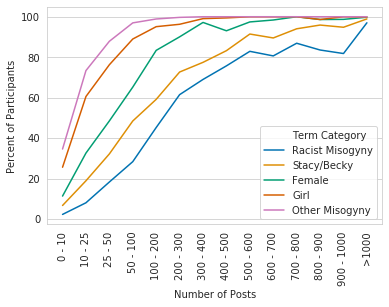

In [38]:
post_data_counts = post_data['username'].value_counts().reset_index(name='number_of_posts').rename(columns={'index': 'username'})
post_data_counts['user_category'] = pd.cut(post_data_counts['number_of_posts'], bins=[0, 10, 25, 50, 100,200,300,400,500,600,700,800,900,1000, 1000000])
#all_misogyny = table1_query_data[table1_query_data['query_category'] == 'Total Misogyny']
all_misogyny = table1_query_data

binned_users = {'Users with _ up to _ posts': [], '% Using Misogynistic Terms': [], 'Number of Users in Category': [], 'Number of Users in Category Using Any Misogynistic Term': [], 'Term Category': []}
for user_category in post_data_counts['user_category'].dropna().sort_values().unique():
    
    usernames_in_category = post_data_counts.loc[post_data_counts['user_category'] == user_category, 'username'].values
    
    for term_category in table1_query_data['query_category'].unique():
        
        if term_category in ['Homophobic Misogyny', 'Transphobic']:
            pass
        
        term_category_df = all_misogyny.loc[all_misogyny['query_category'] == term_category]
        
        queries_by_usernames_in_category = term_category_df.loc[term_category_df['username'].isin(usernames_in_category), 'username'].unique()

        perc_of_users_in_category_using_terms = len(queries_by_usernames_in_category) / len(usernames_in_category) * 100

        binned_users['Number of Users in Category'].append(len(usernames_in_category))
        binned_users['Number of Users in Category Using Any Misogynistic Term'].append(len(queries_by_usernames_in_category))
        binned_users['Users with _ up to _ posts'].append(user_category)
        binned_users['% Using Misogynistic Terms'].append(perc_of_users_in_category_using_terms)
        binned_users['Term Category'].append(term_category)
    
binned_users = pd.DataFrame(binned_users)
binned_users['Users with _ up to _ posts'] = binned_users['Users with _ up to _ posts'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', ' - ').str.replace('1000 - 1000000', '>1000')


ax = sns.lineplot(data = binned_users, sort= False, hue_order=table1.drop(['Transphobic', 'Total Misogyny', 'Women/Lady']).index,  y='% Using Misogynistic Terms', x='Users with _ up to _ posts', hue='Term Category')# kind='bar', palette='viridis_r')
plt.xticks(rotation=90)
plt.ylabel('Percent of Participants')
plt.xlabel('Number of Posts')
ax.xaxis.grid(False)
plt.savefig("user_bin_plot_lines_non_profile.png", dpi=300, bbox_inches='tight')
binned_users.to_csv('binned_user_data_all_categories_non_profile.tsv', sep='\t', index=False)

In [41]:
!pwd

/home/fin/documents/research/social/incel_social_media/incels_co


In [44]:
table1.iloc[:5].sum()

Number of uses                         960487.000000
Posts with term (%)                        19.380024
Threads with term in title (%)             18.140970
Threads with term in first post (%)        51.473252
Threads with term anywhere (%)            167.078550
Participants using term (%)               250.664207
dtype: float64

In [45]:
table1

,Number of uses,Posts with term (%),Threads with term in title (%),Threads with term in first post (%),Threads with term anywhere (%),Participants using term (%)
Racist Misogyny,33336,0.755946,0.768022,1.532258,8.650187,29.963100
Stacy/Becky,41047,0.913999,0.907490,3.174954,13.625607,38.499385
Female,115019,2.438451,2.483292,7.906146,31.707256,48.499385
Girl,200224,4.076303,4.116522,14.370910,41.855622,63.247232
Other Misogyny,570861,11.195325,9.865643,24.488985,71.239879,70.455105
Total Misogyny,960487,17.344111,17.717517,39.429758,82.341805,81.242312
Women/Lady,402045,7.303607,7.944642,20.764362,57.796654,67.712177
Transphobic,11280,0.267708,0.167236,0.451852,3.578213,19.778598


In [9]:
misogyny_terms = ['whore', 'hole', 'foid', 'femoid',
       'bitch', 'cunt', 'toilet', 'pussy', 'noodle', 'slut', 'mommy',
       'gold digger', 'roastie', 'landwhale', 'feminazi',
       'JB', 'escort', 'stacy',
       'slit', 'becky', 'bird', 'twat', 'skank',
       'dyke', 'prostitute', 'gash', 'cum dumpster', 
       'bimbo', 'cum receptacle', 'thot', 'plain jane',
       'femcel', 'jailbait', 'milf', 'karen', 'axe wound',
       'sloot',
       'shit cunt', 'hog', 'HQNP', 'puta', 'ho', 'warpig', 'BBV',
       'fat ugly woman', 'lesbo', 'fat cow',
       'gutterwhore', 'cock tease', 'butterface',
       'shemale', 'roast beef whores', 'ditz',
       'hatchet wound', 'lez', 'gookette', 'milk truck',
       'big black vagina', 'sperm receptacle', 'scag', 
       'yellow cab', 'mammy', 'bim', 'JAP', 'jewish american princess',
       'butterbody', 'muffdiver', 'milk factory']

query_data[query_data['query_term'].isin(misogyny_terms)]['query_term'].value_counts().nlargest(25).to_csv('top25_misogyny_terms.csv')
query_data['query_term'].value_counts().nlargest(25).to_csv('top25_all_term_counts.csv')

In [11]:
spacy_noun_counts = pd.read_csv('2021_04_15_scrape/2021_04_15_inceldom_discussion_scrape/noun_counts.tsv', sep='\t').rename(columns={'Unnamed: 0': 'Rank'})
spacy_noun_counts = spacy_noun_counts.dropna()
spacy_noun_counts = spacy_noun_counts[~spacy_noun_counts['noun'].str.contains('lightbox')]

Now to get the top 25 terms used (and counts) from the query data (as well as a validity check using  `extract_all_nouns.py` and listed in `noun_counts.tsv`)

In [12]:
spacy_noun_counts[['noun', 'count']].iloc[:100].to_csv('top100_nouns.tsv', sep='\t')

In [13]:
query_data['query_term'].value_counts().head(25).to_csv('top_25_query_terms.tsv', sep='\t')

In [14]:
with open('test.txt', 'w') as fh:
    for i in query_data['query_term'].unique():
        sub = query_data.loc[query_data['query_term'] == i, 'query_sentence'].sample(20, replace=True)
        fh.write("\n\n@!" + i + '\n')
        for comment in sub.values:
            fh.write(comment.strip() + '\n')

Graph of "all misogyny" terms by user in bins of ten posts. For the X-axis, can you indicate the # of posts by 100, up to a maximum of 1000 posts. y-axis is % of users. Please let me know if this one is unclear. 

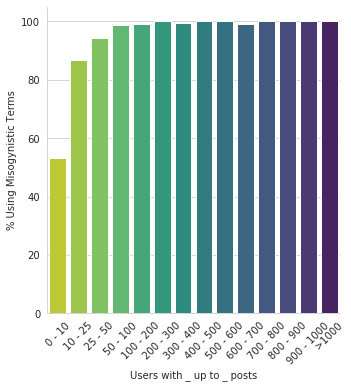

In [30]:
user_data['user_category'] = pd.cut(user_data['number_of_posts'], bins=[0, 10, 25, 50, 100,200,300,400,500,600,700,800,900,1000, 1000000])
all_misogyny = table1_query_data[table1_query_data['query_category'] == 'Total Misogyny']

binned_users = {'Users with _ up to _ posts': [], '% Using Misogynistic Terms': [], 'Number of Users in Category': [], 'Number of Users in Category Using Any Misogynistic Term': []}
for user_category in user_data['user_category'].dropna().sort_values().unique():
    usernames_in_category = user_data.loc[user_data['user_category'] == user_category, 'username'].values
    
    queries_by_usernames_in_category = all_misogyny.loc[all_misogyny['username'].isin(usernames_in_category), 'username'].unique()
    
    perc_of_users_in_category_using_terms = len(queries_by_usernames_in_category) / len(usernames_in_category) * 100
    
    binned_users['Number of Users in Category'].append(len(usernames_in_category))
    binned_users['Number of Users in Category Using Any Misogynistic Term'].append(len(queries_by_usernames_in_category))
    binned_users['Users with _ up to _ posts'].append(user_category)
    binned_users['% Using Misogynistic Terms'].append(perc_of_users_in_category_using_terms)
    
binned_users = pd.DataFrame(binned_users)
binned_users['Users with _ up to _ posts'] = binned_users['Users with _ up to _ posts'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', ' - ').str.replace('1000 - 1000000', '>1000')
sns.catplot(data = binned_users, y='% Using Misogynistic Terms', x='Users with _ up to _ posts', kind='bar', palette='viridis_r')
plt.xticks(rotation=45)
plt.savefig("user_bin_plot.png", dpi=300, bbox_inches='tight')
binned_users.to_csv('binned_user_data.tsv', sep='\t', index=False)


In [31]:
previous = binned_users 

In [18]:
table1_query_data.to_csv('table1_query_data_results.csv', sep='\t')

In [19]:
table1_query_data[table1_query_data['query_category'] == 'Women/Lady'].sample(1000)[['query_term', 'query_sentence']].to_csv('1000_random_uses_of_neutral_women.csv', sep='\t',index=False)

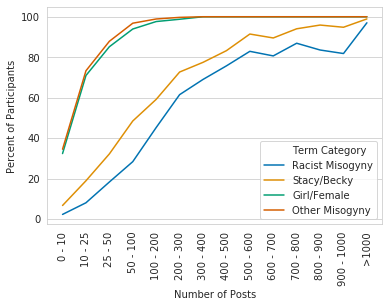

In [20]:
post_data_counts = post_data['username'].value_counts().reset_index(name='number_of_posts').rename(columns={'index': 'username'})
post_data_counts['user_category'] = pd.cut(post_data_counts['number_of_posts'], bins=[0, 10, 25, 50, 100,200,300,400,500,600,700,800,900,1000, 1000000])
#all_misogyny = table1_query_data[table1_query_data['query_category'] == 'Total Misogyny']
all_misogyny = table1_query_data

binned_users = {'Users with _ up to _ posts': [], '% Using Misogynistic Terms': [], 'Number of Users in Category': [], 'Number of Users in Category Using Any Misogynistic Term': [], 'Term Category': []}
for user_category in post_data_counts['user_category'].dropna().sort_values().unique():
    
    usernames_in_category = post_data_counts.loc[post_data_counts['user_category'] == user_category, 'username'].values
    
    for term_category in table1_query_data['query_category'].unique():
        
        if term_category in ['Homophobic Misogyny', 'Transphobic']:
            pass
        
        term_category_df = all_misogyny.loc[all_misogyny['query_category'] == term_category]
        
        queries_by_usernames_in_category = term_category_df.loc[term_category_df['username'].isin(usernames_in_category), 'username'].unique()

        perc_of_users_in_category_using_terms = len(queries_by_usernames_in_category) / len(usernames_in_category) * 100

        binned_users['Number of Users in Category'].append(len(usernames_in_category))
        binned_users['Number of Users in Category Using Any Misogynistic Term'].append(len(queries_by_usernames_in_category))
        binned_users['Users with _ up to _ posts'].append(user_category)
        binned_users['% Using Misogynistic Terms'].append(perc_of_users_in_category_using_terms)
        binned_users['Term Category'].append(term_category)
    
binned_users = pd.DataFrame(binned_users)
binned_users['Users with _ up to _ posts'] = binned_users['Users with _ up to _ posts'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', ' - ').str.replace('1000 - 1000000', '>1000')


ax = sns.lineplot(data = binned_users, sort= False, hue_order=table1.drop(['Transphobic', 'Homophobic Misogyny', 'Total Misogyny', 'Women/Lady']).index,  y='% Using Misogynistic Terms', x='Users with _ up to _ posts', hue='Term Category')# kind='bar', palette='viridis_r')
plt.xticks(rotation=90)
plt.ylabel('Percent of Participants')
plt.xlabel('Number of Posts')
ax.xaxis.grid(False)
plt.savefig("user_bin_plot_lines_non_profile.png", dpi=300, bbox_inches='tight')
binned_users.to_csv('binned_user_data_all_categories_non_profile.tsv', sep='\t', index=False)

In [21]:
binned_users

,Users with _ up to _ posts,% Using Misogynistic Terms,Number of Users in Category,Number of Users in Category Using Any Misogynistic Term,Term Category
0,0 - 10,31.113998,3079,958,Women/Lady
1,0 - 10,34.524196,3079,1063,Other Misogyny
2,0 - 10,32.380643,3079,997,Girl/Female
3,0 - 10,0.682040,3079,21,Transphobic
4,0 - 10,2.305943,3079,71,Racist Misogyny
...,...,...,...,...,...
107,>1000,85.663082,837,717,Transphobic
108,>1000,97.013142,837,812,Racist Misogyny
109,>1000,98.924731,837,828,Stacy/Becky
110,>1000,36.798088,837,308,Homophobic Misogyny


In [ ]:
 6)    The % of posts with a neutral term for women that also include any other misogynistic term (i.e., all the categories).  

7)    The % of posts with a neutral term for women that also include any “other misogyny.”  

8)    The % of posts with a neutral term for women that also include any “racist misogyny.”  



In [96]:
posts_with_neutral = query_data.groupby(['thread_url', 'post_position'])['query_category'].unique()
posts_with_neutral = posts_with_neutral[posts_with_neutral.apply(lambda x: 'Women/Lady' in x or 'Girl/Female' in x)]

any_misogyny = posts_with_neutral[posts_with_neutral.apply(lambda x: len(set(x) - set(['Women/Lady', 'Girl/Female'])) > 0)]
other_misogyny = posts_with_neutral[posts_with_neutral.apply(lambda x: 'Other Misogyny' in x)]
racist_misogyny = posts_with_neutral[posts_with_neutral.apply(lambda x: 'Racist Misogyny' in x)]

In [119]:
print("% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any other misogynistic term:", any_misogyny.shape[0] / total_posts * 100, "%")
print("% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any “other misogyny:", other_misogyny.shape[0] / total_posts * 100, "%")
print("% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any “racist misogyny:", racist_misogyny.shape[0] / total_posts * 100, "%")

% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any other misogynistic term: 2.65350193021912 %
% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any “other misogyny: 2.33660959656657 %
% of posts with a neutral term for women (Women/Lady, Girl/Female) that also include any “racist misogyny: 0.18146501325245312 %


In [36]:
from datetime import datetime
print(datetime.utcfromtimestamp(post_data['post_time'].min()).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.utcfromtimestamp(post_data['post_time'].max()).strftime('%Y-%m-%d %H:%M:%S'))

2017-11-08 02:49:06
2021-04-16 01:16:38
